# Match DMRs to featureCounts matrix

In [38]:
# import DMR dataframes from txt file 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in DMR data
dmrNA = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/NvsA_gene_ids.txt', sep='\t', header=None)
dmrNR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/NvsR_gene_ids.txt', sep='\t', header=None)
dmrAR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/AvsR_gene_ids.txt', sep='\t', header=None)

In [39]:
# import fetaure cpounts (gene expression data)
expression = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/9_create_GeneCountsMatrix/gene_matrix_count.csv', sep=',', index_col=0)

In [40]:
# convert df to list for all DMR dataframes
dmrna = dmrNA[0].to_list()
dmrnr = dmrNR[0].to_list()
dmrar = dmrAR[0].to_list()

In [41]:
# filter the expression data for the DMRs
expressionNA = expression[expression.index.isin(dmrna)]
expressionNR = expression[expression.index.isin(dmrnr)]
expressionAR = expression[expression.index.isin(dmrar)]

# Filter out low expression 


In [42]:
# filter the rows that have as a sum less than 50 counts
expressionNA = expressionNA[(expressionNA.sum(axis=1) >= 50)]
expressionNR = expressionNR[(expressionNR.sum(axis=1) >= 50)]
expressionAR = expressionAR[(expressionAR.sum(axis=1) >= 50)]

In [43]:
# reorder the columns of the expression dataframes
# Specify the desired column order
column_order = ['N1', 'N2', 'N3', 'N7', 'A1', 'A2', 'A4', 'A7', 'R2', 'R3', 'R7', 'R8']

# Reorder the dataframe columns
expressionNA = expressionNA.reindex(columns=column_order)
expressionNR = expressionNR.reindex(columns=column_order)
expressionAR = expressionAR.reindex(columns=column_order)



In [44]:
expressionNA.head(5)

,N1,N2,N3,N7,A1,A2,A4,A7,R2,R3,R7,R8
Geneid,,,,,,,,,,,,
ccar_ua01-ccar_g416,300,269,319,284,280,196,231,258,375,350,351,204
ccar_ub01-ccar_g41306,1598,1424,1412,1464,871,590,932,799,1490,1032,1112,1017
ccar_ub01-ccar_g41399,137,102,124,134,83,77,82,59,79,71,136,53
ccar_ub01-ccar_g41400,1376,1266,1401,1381,1320,970,1019,1046,1309,1269,1328,1125
ccar_ua02-ccar_g4256,165,183,140,161,89,107,108,82,209,142,148,150


# Z-scaling 

In [45]:
# Calculate the mean and standard deviation for each gene across samples
meanNA = expressionNA.mean(axis=1)
meanNR = expressionNR.mean(axis=1)
meanAR = expressionAR.mean(axis=1)

std_devNA = expressionNA.std(axis=1)
std_devNR = expressionNR.std(axis=1)
std_devAR = expressionAR.std(axis=1)


# Perform Z scaling on the data
expressionNA = (expressionNA.sub(meanNA, axis=0)).div(std_devNA, axis=0)
expressionNR = (expressionNR.sub(meanNR, axis=0)).div(std_devNR, axis=0)
expressionAR = (expressionAR.sub(meanAR, axis=0)).div(std_devAR, axis=0)

# Clustering

In [52]:
import numpy as np
from Bio.Cluster import distancematrix

# convert feature count matrix in to an continous np array 
expressionNA_contiguous = np.ascontiguousarray(expressionNA)

# Use the modified data to calculate the distance matrix
distances = distancematrix(expressionNA_contiguous, dist='e')

In [37]:
from Bio.Cluster import clustercentroids

# calculating the cluster centroids 
# calculates the arithmetic mean --> to calculate the cluster center 
cdata, cmask = clustercentroids(expressionNA_contiguous)

In [54]:
from Bio.Cluster import treecluster
tree = treecluster(expressionNA_contiguous)

In [55]:
tree

In [ ]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = hierarchy.linkage(expressionNA, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure()
plt.title('Dendrogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Gene Expression')
dn = hierarchy.dendrogram(Z)
plt.show()

Text(0.5, 0, 'Gene Expression')

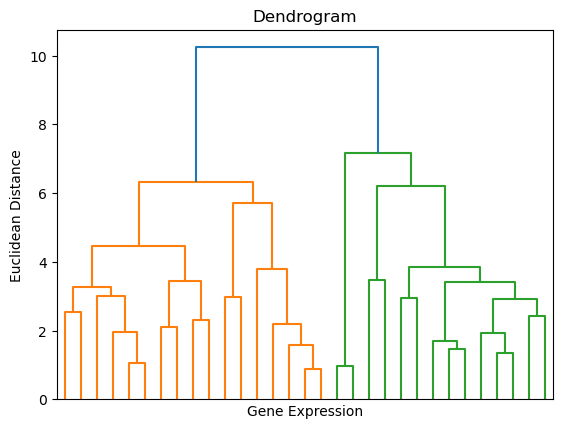

In [63]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Perform hierarchical clustering
dendrogram = sch.dendrogram(sch.linkage(expressionNA, method='ward', metric='euclidean'), no_labels=True)

# Plot the dendrogram
plt.title('Dendrogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Gene Expression')


In [77]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=5)
hc.fit(expressionNA)

AgglomerativeClustering(n_clusters=5)

In [78]:
hc.n_clusters_

5

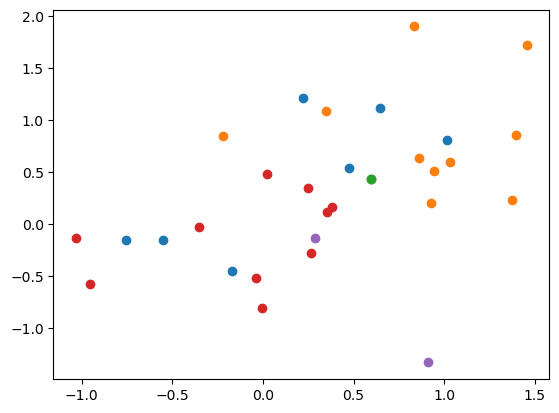

In [79]:
# visualize the clusters
for i in range(hc.n_clusters_):
    plt.scatter(expressionNA.iloc[hc.labels_ == i, 0], expressionNA.iloc[hc.labels_ == i, 1], label='Cluster ' + str(i + 1))

In [25]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)  # Set the number of clusters as per requirement
cluster_assignments = kmeans.fit_predict(expressionNA)

# Now cluster_assignments will contain the cluster labels for each data point

/home/maggy/anaconda3/envs/methylscore/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# PLOT

In [26]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl

In [27]:
# Normoxia vs Anoxia 
row_labelNA = expressionNA.index.to_numpy()
col_labelNA = expressionNA.columns.to_numpy()
dataNA = expressionNA.to_numpy()

# Normoxia vs Reoxygenation
row_labelNR = expressionNR.index.to_numpy()
col_labelNR = expressionNR.columns.to_numpy()
dataNR = expressionNR.to_numpy()

# Anoxia vs Reoxygenation 
row_labelAR = expressionAR.index.to_numpy()
col_labelAR = expressionAR.columns.to_numpy()
dataAR = expressionAR.to_numpy()

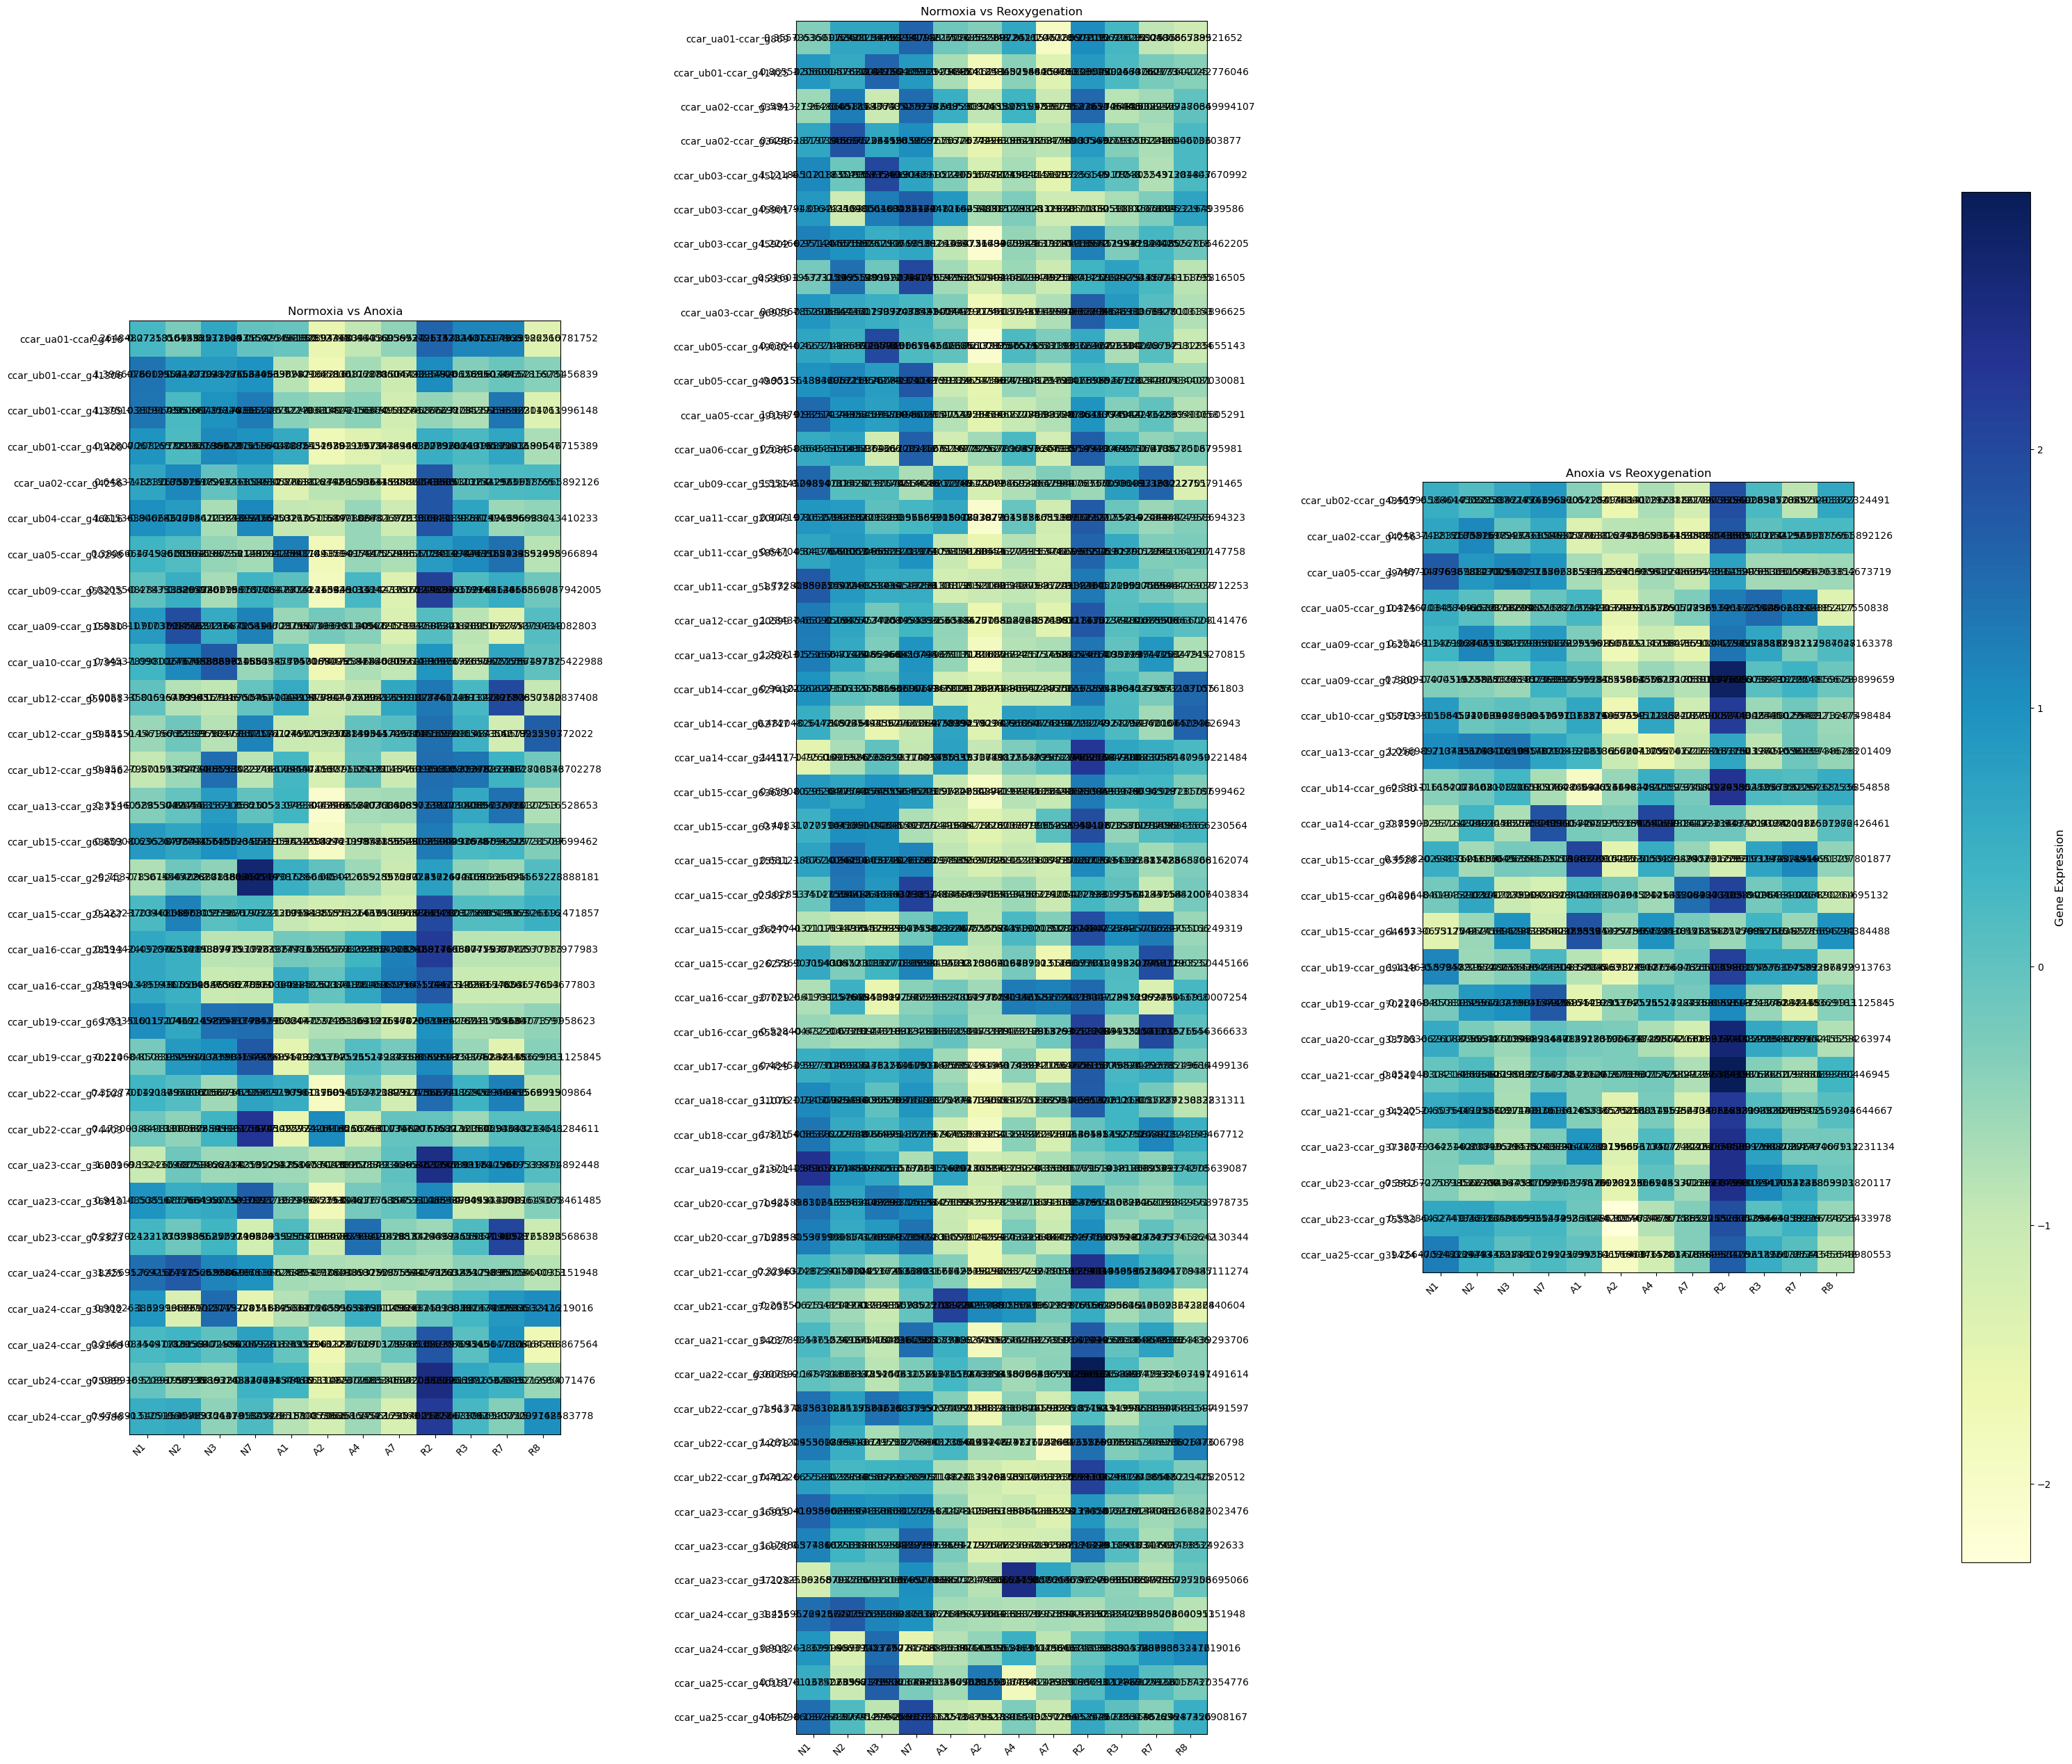

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(40, 32), gridspec_kw={'wspace': 0.5})

# Find the overall min and max values from all data arrays
overall_min = min(dataNA.min(), dataNR.min(), dataAR.min())
overall_max = max(dataNA.max(), dataNR.max(), dataAR.max())

# Plot the heatmaps with adjusted scale
plot_titles = ["Normoxia vs Anoxia", "Normoxia vs Reoxygenation", "Anoxia vs Reoxygenation"]
for i, data in enumerate([dataNA, dataNR, dataAR]):
    row_label, col_label = [row_labelNA, row_labelNR, row_labelAR][i], [col_labelNA, col_labelNR, col_labelAR][i]
    
    im = axs[i].imshow(data, cmap="YlGnBu", vmin=overall_min, vmax=overall_max)

    for r in range(len(row_label)):
        for c in range(len(col_label)):
            axs[i].text(c, r, data[r, c], ha='center', va='center', color='black')

    axs[i].set_title(plot_titles[i])
    axs[i].set_xticks(np.arange(len(col_label)))
    axs[i].set_yticks(np.arange(len(row_label)))
    axs[i].set_xticklabels(col_label)
    axs[i].set_yticklabels(row_label)
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right")

# Create a single colorbar for all subplots using the overall min and max values
cbar = fig.colorbar(im, ax=axs, shrink=0.8, location='right')
cbar.set_label("Gene Expression", fontsize=12)

plt.show()
# save the plot
fig.savefig('8_DMR_gene_expression/DMR_gene_expression_heatmap.png')
# save as pdf 
fig.savefig('8_DMR_gene_expression/DMR_gene_expression_heatmap.pdf')
fig.savefig('8_DMR_gene_expression/DMR_gene_expression_heatmap.tiff')
